### Урок 4. Тематическое моделирование. EM-алгоритм

#### Домашнее задание

1. объединить в одну выборку (это только для твитов), для роспотребнадзора сформировать датасет из вопросов
2. провести исследование и выявить тематики о которых говорят в твитах (для твитов), а для роспотребнадзора так же выявить тематики о которых люди пишут проанализировать
3. сделать визуализацию кластеров тематик
4. проинтерпритировать получившиеся тематики

In [1]:
!pip install corus

In [2]:
!pip install pyLDAvis

In [3]:
!pip install pymorphy2

In [4]:
!pip install stop_words

In [7]:
!pip uninstall numpy

Found existing installation: numpy 1.26.0
Uninstalling numpy-1.26.0:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/lib/python3.10/dist-packages/numpy-1.26.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-0cf96a72.3.23.dev.so
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.10/dist-packages/numpy/*
Proceed (Y/n)? y
  Successfully uninstalled numpy-1.26.0


In [8]:
!pip install numpy

  Using cached numpy-1.26.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.26.0 which is incompatible.
tensorflow 2.13.0 requires numpy<=1.24.3,>=1.22, but you have numpy 1.26.0 which is incompatible.


In [5]:
import pandas as pd

import re
from tqdm import tqdm
from tqdm.notebook import tqdm
from tqdm import notebook

import nltk

nltk.download('punkt')
nltk.download('stopwords')
import pymorphy2
import string
from pymorphy2 import MorphAnalyzer
from stop_words import get_stop_words
from nltk.corpus import stopwords
from multiprocessing import Pool
from pymystem3 import Mystem


from gensim.models import *
from gensim import corpora

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### Объеденяем 2 датасета в 1 выборку и делаем предобработку текста как для дз к 3 уроку

In [6]:
!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


--2023-10-10 10:25:27--  https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/fnpq3z4bcnoktiv/positive.csv [following]
--2023-10-10 10:25:27--  https://www.dropbox.com/s/raw/fnpq3z4bcnoktiv/positive.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc7a640e34232a6b8aecf953c95.dl.dropboxusercontent.com/cd/0/inline/CFUgBbvltz7n_TThwAZp4kkMW4ZRtE3syMaDcgIdJbO6t63fHq0pg3xZPnvt7PxDRMPEPt0g_jCAJfcbm9XsEqOJygENiMecL76bp_4gulX9OmXhRqXC6Wtrx0rY_lFQuDc/file# [following]
--2023-10-10 10:25:27--  https://ucc7a640e34232a6b8aecf953c95.dl.dropboxusercontent.com/cd/0/inline/CFUgBbvltz7n_TThwAZp4kkMW4ZRtE3syMaDcgIdJbO6t63fHq0pg3xZPnvt7PxDRMPEPt0g_jCAJfcbm9XsEqOJygENiMecL76bp_4gulX9OmXhRqXC6Wtrx0r

In [7]:
# считываем данные и заполняем общий датасет
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
data = pd.concat([positive, negative])
data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text
0,"@first_timee хоть я и школота, но поверь, у на..."
1,"Да, все-таки он немного похож на него. Но мой ..."
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...
3,"RT @digger2912: ""Кто то в углу сидит и погибае..."
4,@irina_dyshkant Вот что значит страшилка :D\nН...
...,...
111918,Но не каждый хочет что то исправлять:( http://...
111919,скучаю так :-( только @taaannyaaa вправляет мо...
111920,"Вот и в школу, в говно это идти уже надо("
111921,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :..."


#### Предобработка текста

In [8]:
def user_delete_re_sub (pattern, repl, string):
    return re.sub(pattern, repl, string)

data.text = np.vectorize(user_delete_re_sub)('@[\w]*', '', data.text)
data.text = np.vectorize(user_delete_re_sub)('http*', '', data.text)
data.text = np.vectorize(user_delete_re_sub)('это*', '', data.text)
data.text = np.vectorize(user_delete_re_sub)('всё*', '', data.text)
data.text = np.vectorize(user_delete_re_sub)('ещё*', '', data.text)
data.text = np.vectorize(user_delete_re_sub)('знать*', '', data.text)
data.text = np.vectorize(user_delete_re_sub)('посмотреть*', '', data.text)
data.text = np.vectorize(user_delete_re_sub)('сой*', '', data.text)

data.head(5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:4: DeprecationWarning: invalid escape sequence '\w'
<>:4: DeprecationWarning: invalid escape sequence '\w'
<ipython-input-8-bcdd89e40b2d>:4: DeprecationWarning: invalid escape sequence '\w'
  data.text = np.vectorize(user_delete_re_sub)('@[\w]*', '', data.text)


,text
0,"хоть я и школота, но поверь, у нас то же само..."
1,"Да, е-таки он немного похож на него. Но мой ма..."
2,RT : Ну ты идиотка) я испугалась за тебя!!!
3,"RT : ""Кто то в углу сидит и погибает от голода..."
4,"Вот что значит страшилка :D\nНо блин,посмотре..."


In [9]:
morph = pymorphy2.MorphAnalyzer()
words_regex = re.compile('\w+')

def find_words(text, regex = words_regex):
    tokens =  regex.findall(text.lower())
    return [w for w in tokens if w.isalpha() and len(w) >= 3]


stopwords_list = stopwords.words('russian')

def lemmatize(words, lemmer = morph, stopwords = stopwords_list):
    lemmas = [lemmer.parse(w)[0].normal_form for w in words]
    return [w for w in lemmas if not w in stopwords
            and w.isalpha()]

def preprocess(text):
    return (lemmatize(find_words(text)))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:2: DeprecationWarning: invalid escape sequence '\w'
<>:2: DeprecationWarning: invalid escape sequence '\w'
<ipython-input-9-d59fa9b0441f>:2: DeprecationWarning: invalid escape sequence '\w'
  words_regex = re.compile('\w+')
/usr/local/lib/python3.10/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/usr/local/lib/python3.10/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signatur

In [10]:
data.text.iloc[777]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


' нет...предупреждает, что их власть надолго...но думаю опять переоценил он свои возможности..алкоголь не даст дожить до 70))'

In [11]:
print(preprocess(data.text.iloc[777]))

['предупреждать', 'власть', 'надолго', 'думать', 'переоценить', 'свой', 'возможность', 'алкоголь', 'дать', 'дожить']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
# оставляем случайные 10000 текстов, чтобы ускорить вычисления
data = data.sample(10000)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
preprocessed_text = list(tqdm(map(preprocess, data['text']), total=len(data)))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [14]:
data['text'] = preprocessed_text
data.sample(3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text
97903,"[загс, ужасный, очередь]"
21161,"[очень, правдивый, хотеть, порвать, сегодня]"
78094,"[курица, гриль, отобрать, дурацкий, привычка, ..."


#### Модель LDA

In [15]:
dictionary = corpora.Dictionary(data['text'])

dictionary.filter_extremes(no_below = 3, no_above = 0.9, keep_n=None) # игнорируем слова, которые встречаются реже 3 раз или составляют более 0.9 словаря
dictionary.save('tweeter.dict')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
corpus = [dictionary.doc2bow(text) for text in data['text']]
corpora.MmCorpus.serialize('tweeter.model', corpus)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=20, chunksize=50, update_every=1, passes=2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Посмотрим 5 основных тематик о которых говорят в твитах

In [18]:
lda.show_topics(num_topics=5, num_words=5, formatted=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(12,
  '0.201*"час" + 0.154*"давать" + 0.113*"поход" + 0.110*"ходить" + 0.068*"интересно"'),
 (16,
  '0.399*"сегодня" + 0.331*"знать" + 0.036*"город" + 0.027*"красиво" + 0.025*"окно"'),
 (8,
  '0.309*"дом" + 0.169*"большой" + 0.106*"надеяться" + 0.105*"нибыть" + 0.038*"мечта"'),
 (15,
  '0.186*"понимать" + 0.153*"нравиться" + 0.130*"пока" + 0.130*"скучать" + 0.107*"сколько"'),
 (10,
  '0.000*"признаться" + 0.000*"принц" + 0.000*"подружиться" + 0.000*"любовник" + 0.000*"подняться"')]

#### Визуализируем кластеры тематик

In [19]:
vis_data = gensimvis.prepare(lda, corpus, dictionary, mds='mmds')
pyLDAvis.display(vis_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


#### Интерпретируем получившиеся тематики

In [20]:
lda.show_topics(num_topics=10, num_words=10, formatted=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(6,
  '0.290*"остаться" + 0.080*"смочь" + 0.079*"ребёнок" + 0.000*"милый" + 0.000*"добрый" + 0.000*"оказываться" + 0.000*"врач" + 0.000*"последний" + 0.000*"неделя" + 0.000*"пиво"'),
 (19,
  '0.285*"спасибо" + 0.168*"сидеть" + 0.071*"новогодний" + 0.058*"фотка" + 0.053*"прекрасный" + 0.046*"воскресение" + 0.037*"народ" + 0.030*"євромайдан" + 0.021*"добро" + 0.013*"сайт"'),
 (17,
  '0.217*"проснуться" + 0.140*"лишь" + 0.080*"свет" + 0.041*"уйти" + 0.023*"уснуть" + 0.000*"чав" + 0.000*"мочь" + 0.000*"утро" + 0.000*"бытие" + 0.000*"последний"'),
 (11,
  '0.402*"хотеть" + 0.390*"день" + 0.041*"помощь" + 0.022*"помогать" + 0.001*"таблетка" + 0.000*"рождение" + 0.000*"свой" + 0.000*"никто" + 0.000*"офигенный" + 0.000*"весь"'),
 (1,
  '0.233*"блин" + 0.154*"первый" + 0.104*"парень" + 0.070*"простить" + 0.066*"долго" + 0.050*"фото" + 0.043*"маленький" + 0.030*"интернет" + 0.024*"брать" + 0.000*"подруга"'),
 (18,
  '0.190*"делать" + 0.151*"говорить" + 0.124*"помнить" + 0.104*"хотеться" + 0.100

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/5 [00:00<?, ?it/s]

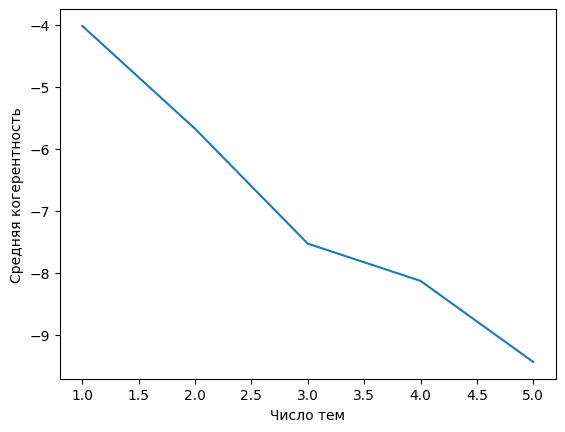

In [22]:
topics_list = [1, 2, 3, 4, 5]
coherences = []

for num in tqdm(topics_list):
    lda = LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda, corpus=corpus, coherence='u_mass').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()